# Problema 2

#### a) Construa um “Control Flow Automaton (CFA)” que determina este programa. Identifique os locais e as transições/ramos.  Numa abordagem orientada às pré-condições  identifique os transformadores de predicados associados aos vários locais e os “switches” associados aos vários ramos.

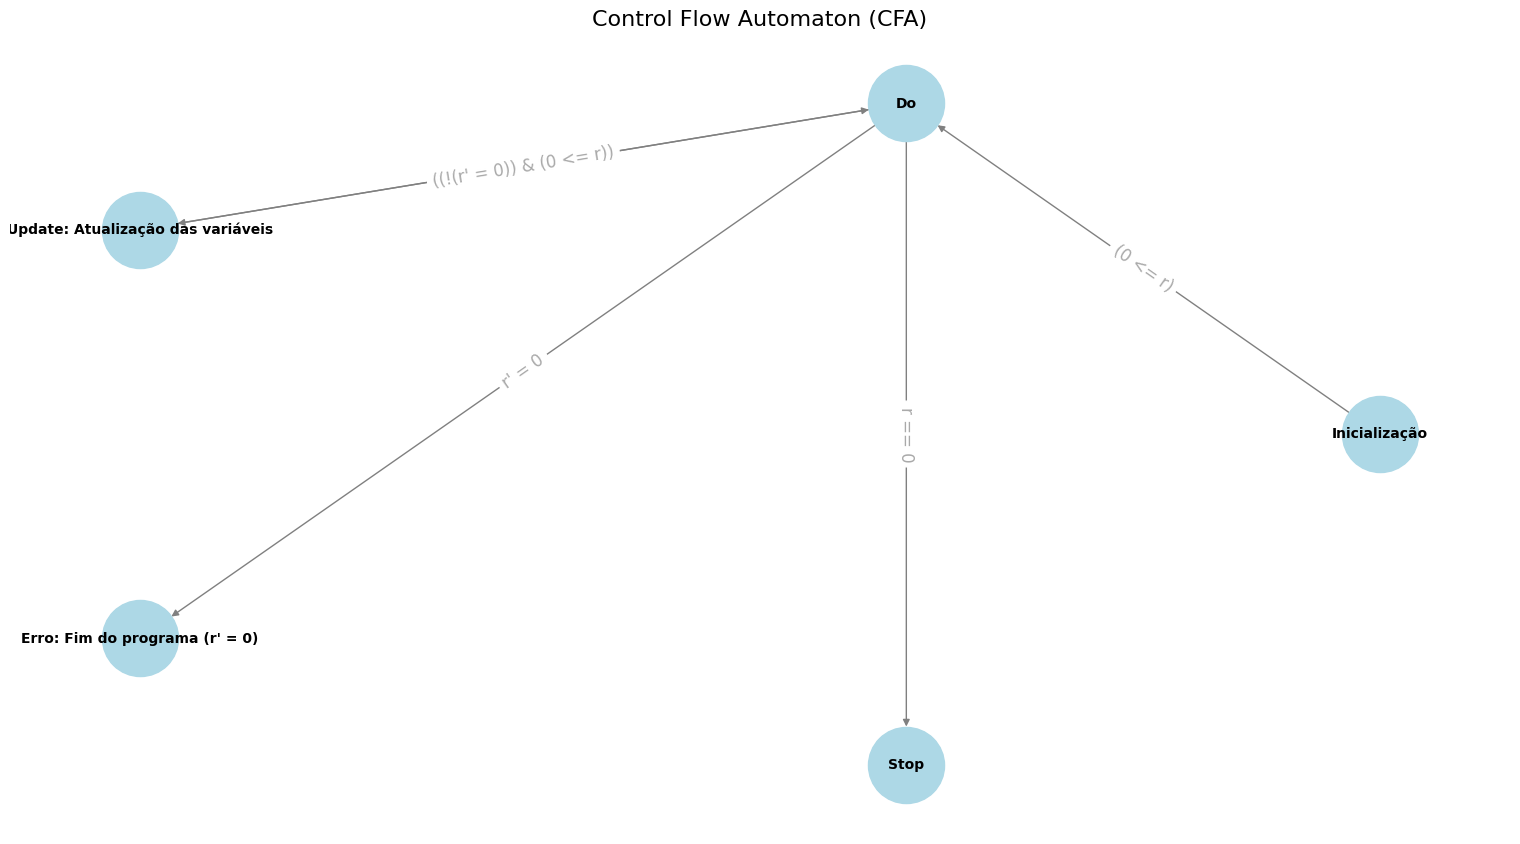

In [38]:
import matplotlib.pyplot as plt
import networkx as nx

# Criação do grafo usando NetworkX
G = nx.DiGraph()

# Adicionando nós
G.add_node('Sistema', label='Inicialização')
G.add_node('Do', label='Do')
G.add_node('Update', label='Update: Atualização das variáveis')
G.add_node('Erro', label='Erro: Fim do programa (r\' = 0)')
G.add_node('Stop', label='Stop')

# Adicionando arestas (transições)
G.add_edge('Sistema', 'Do', label='(0 <= r)')
G.add_edge('Do', 'Update', label='((!(r\' = 0)) & (0 <= r))')
G.add_edge('Do', 'Erro', label='r\' = 0')
G.add_edge('Update', 'Do', label='((!(r\' = 0)) & (0 <= r))')
G.add_edge('Do', 'Stop', label='r == 0')

# Posicionamento dos nós (usando um layout circular para clareza)
pos = nx.circular_layout(G)

# Desenhando o grafo sem labels externos
plt.figure(figsize=(15, 8))
nx.draw(G, pos, with_labels=False, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')

# Adicionando rótulos personalizados dentro dos nós
node_labels = {node: G.nodes[node]['label'] for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_weight='bold', verticalalignment='center')

# Adicionando rótulos nas arestas
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_weight='normal', font_color='darkgray')

# Exibindo o diagrama
plt.title('Control Flow Automaton (CFA)', fontsize=16)
plt.axis('off')  # Desativa o eixo para uma melhor visualização
plt.show()


#### b) Construa em `z3` o sistema de equações que representa o comportamento deste sistema dinâmico sob o ponto de vista da prova de segurança e verifique a segurança do programa através da resolução (total ou parcial) deste sistema. Sugere-se (não é obrigatório mas é valorizado !), na alínea (a), uma representação do CFA através de  um grafo orientado  implementado  em `networkx`  e a sua compilação para o sistema de equações.

In [44]:
from z3 import *

# Definindo as variáveis simbólicas
r = Real('r')
s = Real('s')
t = Real('t')
r_prime = Real('r_prime')
s_prime = Real('s_prime')
t_prime = Real('t_prime')
q = Real('q')

# Definindo as equações que representam o comportamento do algoritmo
eq1 = r_prime == r - q * r_prime  # Equação para r'
eq2 = s_prime == s - q * s_prime  # Equação para s'
eq3 = t_prime == t - q * t_prime  # Equação para t'

# Criando o solver
solver = Solver()

# Adicionando as equações ao solver
solver.add(eq1, eq2, eq3)

# Adicionando as condições de segurança (por exemplo, r' != 0 para evitar um estado de erro)
solver.add(r_prime != 0)

# Verificando se o sistema tem solução
if solver.check() == sat:
    print("Sistema seguro. Soluções possíveis encontradas:")
    print(solver.model())
else:
    print("Sistema não seguro. Nenhuma solução encontrada.")


Sistema seguro. Soluções possíveis encontradas:
[r_prime = 1,
 s_prime = 0,
 q = 0,
 s = 0,
 r = 1,
 t_prime = 0,
 t = 0]
